# Homework 6

---

## Q1: Let's start having some *real* fun...

We previously considered the normal-gamma specification 

$$\scriptsize
\begin{align*}
p(\theta,\tau|x) &\propto{} p(\theta,\tau,x) = p(x|\theta)p(\theta)p(\tau) \quad (\theta \perp\!\!\perp \tau) \leftarrow \text{independent priors} & p(\theta|x,\theta_0,\tau_0, \tau) &={} \text{N}\left(\frac{\left(\tau_0 \theta_0+\tau\sum_{i=1}^{n}x_{i}\right)}{(\tau_0+n\tau)}, \sigma^{-2}=\tau_0+n\tau \right)\\
&={}  \left[\prod_{i=1}^n\sqrt{\frac{\tau}{2\pi}} e^{-\frac{\tau\left(x_i-\theta\right)^2}{2}}\right] \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0\left(\theta-\theta_0\right)^2}{2}} \frac{\beta ^{\alpha}}{\Gamma(\alpha)} \tau^{\alpha -1}e^{-\beta \tau} & p(\tau|x, \alpha, \beta, \theta) &={} \text{Gamma}\left(\frac{\alpha}{2}+\frac{n}{2}, \frac{\beta}{2}+\frac{1}{2}\sum_{i=1}^n\left(x_i-\theta\right)^2 \right)\\{}\\
\end{align*}$$

How about instead we consider a "[location-scale-t](https://en.wikipedia.org/wiki/Student%27s_t-distribution#Location-scale_t-distribution)-norm-halfnorm-discrete-uniform" specification?

$$\large
\overset{x_i\; \sim\; \text{location-scale-t}(\mu, \sigma^2, \nu)}{\quad\quad\quad p(x|\mu,\sigma^2, \nu)} = {\prod_{i=1}^n
\frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right) \sqrt{\pi \nu \sigma^2}}\left(1+\frac{1}{\nu} \frac{(x_i-\mu)^2}{\sigma^2}\right)^{-(\nu+1) / 2}}$$

$$\scriptsize 
\begin{align}
p(\mu | \mu_0, \tau_0) &={} \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0}{2}\left(\mu-\mu_0\right)^2} & p(\sigma^2 | \sigma_0^2) &={} \sqrt{\frac{2}{\pi\sigma_0^2}} \exp \left(-\frac{(\sigma^2)^2}{2 \sigma_0^2}\right) 1_{[0,\infty]}(\sigma^2) & p(\nu=i) &={} \Bigg\{ \begin{array}{cl} \frac{1}{100} & \text{for }i=1,\cdots,100\\ 0 & \text{otherwise} \end{array}\\
& \textrm{normal} && \textrm{half-normal} && \textrm{discrete uniform}
\end{align}
$$

Um yeah we're gonna need a Metroposlis cleanup on aisles one two and three  
(or a slice or adapative squeeze rejection sampling steps... in place of Metroposlis steps)

*Implement the a Metroposlis within Gibbs algorithm to smaple from the posterior of the above specification. Use a "smallish" sample size, say $n=100$ and implement your acceptance probability on a log-scale as described in [piazza post @65_f1](https://piazza.com/class/m5jvyco84083fm/post/65_f1)*

## Answer to Q1

We will use the following specification:

$$\large
\overset{x_i\; \sim\; \text{location-scale-t}(\mu, \sigma^2, \nu)}{\quad\quad\quad p(x|\mu,\sigma^2, \nu)} = {\prod_{i=1}^n
\frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right) \sqrt{\pi \nu \sigma^2}}\left(1+\frac{1}{\nu} \frac{(x_i-\mu)^2}{\sigma^2}\right)^{-(\nu+1) / 2}}$$

$$\scriptsize 
\begin{align}
p(\mu | \mu_0, \tau_0) &={} \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0}{2}\left(\mu-\mu_0\right)^2} & p(\sigma^2 | \sigma_0^2) &={} \sqrt{\frac{2}{\pi\sigma_0^2}} \exp \left(-\frac{(\sigma^2)^2}{2 \sigma_0^2}\right) 1_{[0,\infty]}(\sigma^2) & p(\nu=i) &={} \Bigg\{ \begin{array}{cl} \frac{1}{100} & \text{for }i=1,\cdots,100\\ 0 & \text{otherwise} \end{array}\\
& \textrm{normal} && \textrm{half-normal} && \textrm{discrete uniform}
\end{align}
$$

The acceptance probability should be implemented on a log scale. To make this process easier, work with log scales throughout the process.

### Import Libraries

In [1]:
import numpy as np
from scipy import stats 
import matplotlib.pyplot as plt

### Run Simulation

In [60]:
# Setup parameters
n = 100
lower = 1
upper = 100
mu_0 = 0
tau_0 = 1
sigma2_0 = 1

# Generate synthetic data
x = stats.t(loc=0, scale=1, df=n-1).rvs(size=n)

# MCMC settings
C, G = 2, 10000  # chains, Gibbs samples

# Initialize chains
mu = np.zeros([C, G])
sigma2 = np.zeros([C, G])
nu = np.zeros([C, G])
sigma2[:, 0] = 1
mu[:, 0] = 0
nu[:, 0] = np.random.randint(lower, upper, size=C)

def log_t_likelihood(x, mu, sigma2, nu):
    """Compute log likelihood for t-distribution"""
    return np.sum(stats.t.logpdf(x, df=nu, loc=mu, scale=np.sqrt(sigma2)))

def log_sigma2_prior(sigma2):
    """Compute log prior for sigma2"""
    return stats.halfnorm.logpdf(sigma2, scale=np.sqrt(sigma2_0))

def log_mu_prior(mu):
    """Compute log prior for mu"""
    return stats.norm.logpdf(mu, loc=mu_0, scale=1/np.sqrt(tau_0))

for c in range(C):
    for g in range(1, G):
        # Update sigma2
        sigma2_proposal_scale = 0.1  # Adjust this value based on acceptance rate
        sigma2_tilde = np.abs(sigma2[c, g-1] + stats.norm.rvs(scale=sigma2_proposal_scale))
        
        log_ratio_sigma2 = (
            log_t_likelihood(x, mu[c,g-1], sigma2_tilde, nu[c,g-1]) +
            log_sigma2_prior(sigma2_tilde) -
            log_t_likelihood(x, mu[c,g-1], sigma2[c,g-1], nu[c,g-1]) -
            log_sigma2_prior(sigma2[c,g-1])
        )
        
        if np.log(stats.uniform.rvs()) < log_ratio_sigma2:
            sigma2[c,g] = sigma2_tilde
        else:
            sigma2[c,g] = sigma2[c,g-1]
        
        # Update mu
        mu_proposal_scale = 0.1  # Adjust this value based on acceptance rate
        mu_tilde = mu[c,g-1] + stats.norm.rvs(scale=mu_proposal_scale)
        
        log_ratio_mu = (
            log_t_likelihood(x, mu_tilde, sigma2[c,g], nu[c,g-1]) +
            log_mu_prior(mu_tilde) -
            log_t_likelihood(x, mu[c,g-1], sigma2[c,g], nu[c,g-1]) -
            log_mu_prior(mu[c,g-1])
        )
        
        if np.log(stats.uniform.rvs()) < log_ratio_mu:
            mu[c,g] = mu_tilde
        else:
            mu[c,g] = mu[c,g-1]
            
        # Update nu
        nu_tilde = stats.randint.rvs(lower, upper)
        
        log_ratio_nu = (
            log_t_likelihood(x, mu[c,g], sigma2[c,g], nu_tilde) -
            log_t_likelihood(x, mu[c,g], sigma2[c,g], nu[c,g-1])
        )
        
        if np.log(stats.uniform.rvs()) < log_ratio_nu:
            nu[c,g] = nu_tilde
        else:
            nu[c,g] = nu[c,g-1]

### Visualization

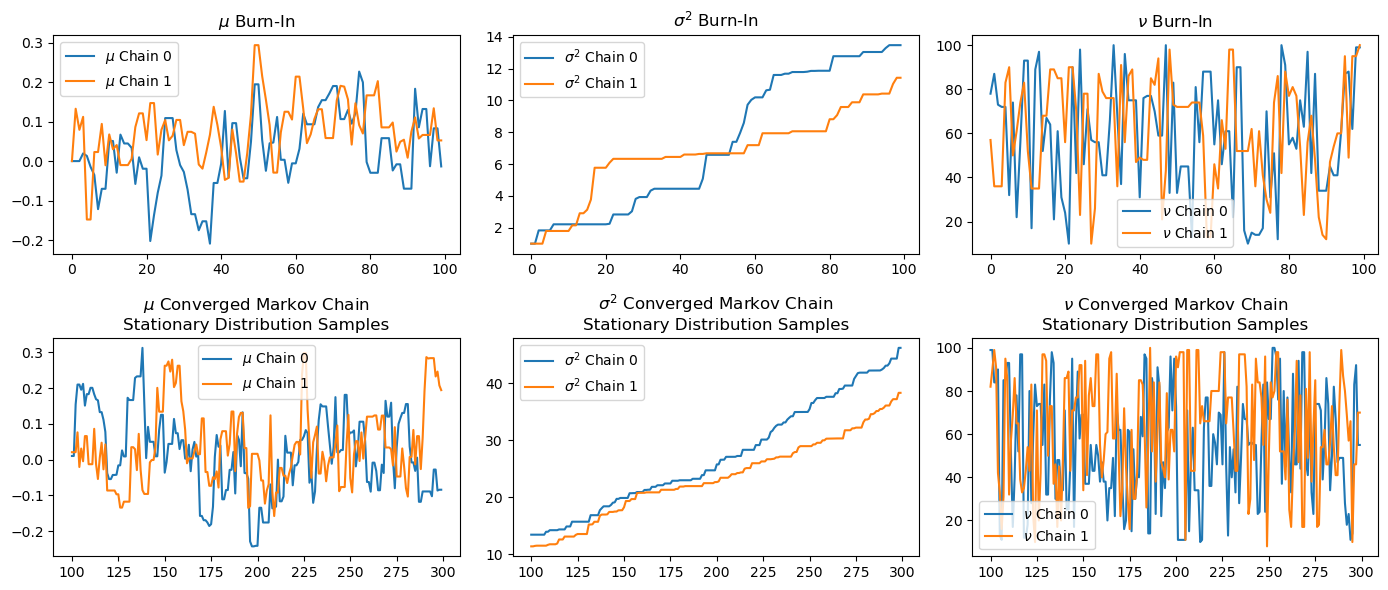

In [61]:
fig, ax = plt.subplots(2, 3, figsize=(14, 6))  # 2 rows, 3 columns
ax[0, 0].set_title("$\\mu$ Burn-In")
ax[0, 1].set_title("$\\sigma^{2}$ Burn-In")
ax[0, 2].set_title("$\\nu$ Burn-In")
ax[1, 0].set_title("$\\mu$ Converged Markov Chain\nStationary Distribution Samples")
ax[1, 1].set_title("$\\sigma^{2}$ Converged Markov Chain\nStationary Distribution Samples")
ax[1, 2].set_title("$\\nu$ Converged Markov Chain\nStationary Distribution Samples")

burn = 100
demo = 300

for c in range(C):
    ax[0, 0].plot(mu[c, :burn], label="$\\mu$ Chain "+str(c))
    ax[0, 1].plot(sigma[c, :burn], label="$\\sigma^{2}$ Chain "+str(c))
    ax[0, 2].plot(nu[c, :burn], label="$\\nu$ Chain "+str(c))
    ax[1, 0].plot(np.arange(burn, demo, dtype=int), mu[c, burn:demo], label="$\\mu$ Chain "+str(c))
    ax[1, 1].plot(np.arange(burn, demo, dtype=int), sigma[c, burn:demo], label="$\\sigma^{2}$ Chain "+str(c))
    ax[1, 2].plot(np.arange(burn, demo, dtype=int), nu[c, burn:demo], label="$\\nu$ Chain "+str(c))

for i in range(2):  
    for j in range(3): 
        ax[i, j].legend()

plt.tight_layout()  
plt.show()


## Q2: explore the role of sample size in providing inference for the degrees of freedom parameter $\nu$

*Implement the specification above using `PyMC` where you can explore inference on $\nu$ at different sample sizes. Provide a summarization and explanation of your findings.*



## Answer to Q2

In [3]:
import pymc as pm
import arviz as az

In [4]:
# Sample sizes
n = [200, 1000, 10000]
true_theta, true_tau = 0, 1  

# data
x1 = stats.t(loc=true_theta, scale=true_tau**(-0.5), df=n[0]-1).rvs(size=n[0])
x2 = stats.t(loc=true_theta, scale=true_tau**(-0.5), df=n[1]-1).rvs(size=n[1])
x3 = stats.t(loc=true_theta, scale=true_tau**(-0.5), df=n[2]-1).rvs(size=n[2])

def run_model(x_obs_data):
    with pm.Model() as model:
        # Prior parameters
        mu0 = 0  
        mu_prior_n = 1 
        sigma2_0 = 1  
        
        tau0 = mu_prior_n * true_tau 
        
        # Priors
        mu = pm.Normal("mu", mu=mu0, sigma=tau0**(-0.5))
        sigma2 = pm.HalfNormal("sigma", sigma=sigma2_0**0.5)
        nu = pm.DiscreteUniform("nu", lower=1, upper=100) 

        # Likelihood
        x_obs = pm.StudentT("x_obs", nu=nu, mu=mu, sigma=sigma2**0.5, observed=x_obs_data)

        # Sampling
        idata = pm.sample(draws=20000, chains=4, tune=1000)

    return idata

# Run models for different sample sizes
idata1 = run_model(x1)
idata2 = run_model(x2)
idata3 = run_model(x3)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 19 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 22 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 41 seconds.


In [5]:
az.summary(idata1, round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-0.06140,0.06442,-0.18013,0.06235,0.00022,0.00019,83983.76884,59640.08210,1.00001
nu,64.58258,22.95017,26.00000,100.00000,0.18185,0.12859,15821.43194,19225.85147,1.00067
sigma,0.89513,0.04643,0.80933,0.98286,0.00017,0.00012,74804.29061,57735.77127,1.00012


In [6]:
az.summary(idata2, round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.00414,0.03138,-0.05393,0.06375,0.00011,0.00011,83641.11521,60980.84776,1.00010
nu,70.36817,19.99051,36.00000,100.00000,0.16234,0.11479,14973.60210,17955.30783,1.00051
sigma,0.97659,0.02294,0.93430,1.02056,0.00009,0.00007,59624.54378,50783.40188,1.00005


In [7]:
az.summary(idata3, round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.01135,0.01004,-0.00760,0.03013,0.00004,0.00003,79279.86619,59073.76802,1.00008
nu,82.75921,13.18935,59.00000,100.00000,0.12471,0.08818,11345.40770,15527.47731,1.00063
sigma,0.99001,0.00749,0.97562,1.00375,0.00003,0.00002,47376.21189,48298.92206,1.00010


### Summary and Explanation of Findings

After running the simulation, we observe that the credible intervals for $\nu$ are wider the smaller the sample sizes are. For example, with $n = 200$, we get a 94% credible interval of $(26, 100)$. This changes to $(36, 100)$ and $(59, 100)$ for $n = 1000$ and $n = 10000$, respectively. With a smaller sample size, there is less information from the likelihood about the distribution of $\nu$. As a result, the posterior distribution of $\nu$ is more dispersed and reflects the higher uncertainty about the true degree of freedom. As $n$ increases, more information from the likelihood is provided and the credible interval for $\nu$ becomes narrower. 

## Q3: the posterior predictive distribution does something like the following...

Let $p(\tau_i)$ be $\require{cancel} \textrm{gamma}\big(\tau_i | \alpha = \frac{\nu}{2}, \overset{\textrm{rate}\xcancel{\textrm{scale}}}{\beta = \frac{\nu}{2}}\big)$ and let $p(y_i|\tau_i)$ be $\textrm{N}(y_i | 0,\tau_i)$ and now integrate out the uncertainty in $\tau_i$ and see what distribution is left over for $y_i$.

*Go look at the gamma distribution and remember that you know that the integrals of unnormalized densities are the inverse of their normalizing constants. Then go look at the t distribution and determine what distribution the following expression defines. Then explain why the behavior demonstrated here is analagous to that of the posterior predictive distribution.*

$$\int p(y_i|\tau_i) p(\tau_i)  d\tau_i = \int \sqrt{\frac{\tau_i}{2\pi}}e^{-\frac{1}{2}\tau_i y_i^2} \frac {\frac{\nu}{2}^{\frac{\nu}{2}}}{\Gamma \left(\frac{\nu}{2}\right)} \tau_i^{\frac{\nu}{2}-1}e^{-\frac{\nu}{2}\tau_i} d\tau_i$$



## Answer to Q3

The integral we are starting with is below:
$$\int p(y_i|\tau_i) p(\tau_i)  d\tau_i = \int \sqrt{\frac{\tau_i}{2\pi}}e^{-\frac{1}{2}\tau_i y_i^2} \frac {\frac{\nu}{2}^{\frac{\nu}{2}}}{\Gamma \left(\frac{\nu}{2}\right)} \tau_i^{\frac{\nu}{2}-1}e^{-\frac{\nu}{2}\tau_i} d\tau_i$$

To solve it, we do the following: <br>
$\begin{align} 
&= \int \sqrt{\frac{\tau_i}{2\pi}}e^{-\frac{1}{2}\tau_i y_i^2} \frac {\frac{\nu}{2}^{\frac{\nu}{2}}}{\Gamma \left(\frac{\nu}{2}\right)} \tau_i^{\frac{\nu}{2}-1}e^{-\frac{\nu}{2}\tau_i} d\tau_i \\
&={} \frac {\frac{\nu}{2}^{\frac{\nu}{2}}}{\Gamma \left(\frac{\nu}{2}\right)} \sqrt{\frac{1}{2\pi}} \int \sqrt{\tau_i}e^{-\frac{1}{2}\tau_i y_i^2}  \tau_i^{\frac{\nu}{2}-1}e^{-\frac{\nu}{2}\tau_i} d\tau_i \\
&={} \frac {\frac{\nu}{2}^{\frac{\nu}{2}}}{\Gamma \left(\frac{\nu}{2}\right)} \sqrt{\frac{1}{2\pi}} \int \tau_i^{\frac{1}{2}}   \tau_i^{\frac{\nu}{2}-1} e^{-\frac{1}{2}\tau_i y_i^2} e^{-\frac{\nu}{2}\tau_i} d\tau_i \\
&={} \frac {\frac{\nu}{2}^{\frac{\nu}{2}}}{\Gamma \left(\frac{\nu}{2}\right)} \sqrt{\frac{1}{2\pi}} \int \tau_i^{\frac{\nu}{2}-\frac{1}{2}} e^{-\frac{1}{2}\tau_i y_i^2 -\frac{\nu}{2}\tau_i} d\tau_i \\
&={} \frac {\frac{\nu}{2}^{\frac{\nu}{2}}}{\Gamma \left(\frac{\nu}{2}\right)} \sqrt{\frac{1}{2\pi}} \int \tau_i^{\frac{\nu}{2}-\frac{1}{2}} e^{- \tau_i \left(\frac{y_i^2}{2} + \frac{\nu}{2} \right)} d\tau_i \\
&={} \frac {\frac{\nu}{2}^{\frac{\nu}{2}}}{\Gamma \left(\frac{\nu}{2}\right)} \sqrt{\frac{1}{2\pi}} \frac{\Gamma \left( \frac{\nu+1}{2} \right)}{\left( \frac{y_i^{2}}{2} + \frac{\nu}{2} \right)^{\frac{\nu+1}{2}}}  \\
&={} \frac{\Gamma \left( \frac{\nu+1}{2} \right)}{\sqrt{\nu \pi}\Gamma\left(\frac{\nu}{2}\right)} \left(1+\frac{y_i^{2}}{\nu} \right)^{- \frac{\nu+1}{2}} \\
\end{align}$

Before integrating, we take out irrelevant parameters and see that we are integrating a gamma distribution. After integration and rearranging terms, we see that the final distribution is a t-distribution, which has heavier tails compared to a Gaussian distribution. The behavior demonstrated here is analagous to that of the posterior predictive distribution. The posterior predictive distribution is the distribution of possible unobserved values, which are conditioned on the observed values. To make new predictions with the posterior predictive distribution, we account for uncertainty by integrating out, or marginalizing, the parameter by taking into account its entire posterior distribution. Our calculation was analogous to this process by integrating out $\tau$. This produced a heavier-tailed distribution for $y_{i}$ and is more robust to outliers. 